# Estimer le prix d'un bien immobilier avec une méthode d'apprentissage machine
### **Pierre-Edouard GUERIN**
#### 01/03/2020

# Introduction

## Contexte
*Demandez à un acheteur de décrire la maison de ses rêves, et il ne commencera probablement pas par la hauteur du plafond du sous-sol ou la proximité d'un chemin de fer est-ouest. Mais ce jeu de données montre que les négociations de prix sont beaucoup plus influencées que le nombre de chambres à coucher ou une clôture en piquets blancs.*

Avec 79 variables explicatives décrivant (presque) tous les aspects de quelques 3000 habitations residentielles à Boston, il faudra définir quelles variables influencent le prix de vente d'un bien immobilier.

## Mission
L'objectif est de prédire le prix de vente d'un jeu de données de biens immobiliers. Pour chaque identifiant de bien immobilier, un prix de vente doit être assigné.

## Script
Ce script utilise des techniques de regression et de transformation des données. D'abord il s'agit de procéder à la curation des données, puis de transformer les descripteurs pour les besoins du modèle. Enfin, la modélisation et la prédiction du prix de vente des biens immobiliers.


# Prérequis

In [1]:
#==============================================================================
#MODULES
#==============================================================================
import argparse
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
import scipy.stats as stats
import xgboost as xgb
import lightgbm as lgb
import warnings


warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')

# Charger et explorer le jeu de données

In [2]:
# download data https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

trainDatFile="data/house_prices_advanced_regression_techniques/train.csv"
testDatFile="data/house_prices_advanced_regression_techniques/test.csv"

train = pd.read_csv(trainDatFile)
test = pd.read_csv(testDatFile)

In [3]:
train.shape

(1460, 81)

In [4]:
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


Le jeu de données présente 81 descripteurs, ce qui est beaucoup alors nous n'allons pas tous les explorer mais nous concentrer sur les plus explicatifs.

De plus, après l'encodage des variables qualitatives nominales, le nombre de colonnes de la nouvelle table risque d'être inutilement trop grand pour nos capacités de calcul.

In [5]:
# variables quantitatives
train.select_dtypes(include=['int64','float64']).columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

Le jeu de donnée contient 38 variables quantitatives et 43 variables qualitatives.

In [6]:
# drop useless "Id" feature
train = train.drop(labels = ["Id"],axis = 1)
test = test.drop(labels = ["Id"],axis = 1)

La variable "Id" (identifiant) n'est pas nécessaire, elle est donc retirée du jeu.

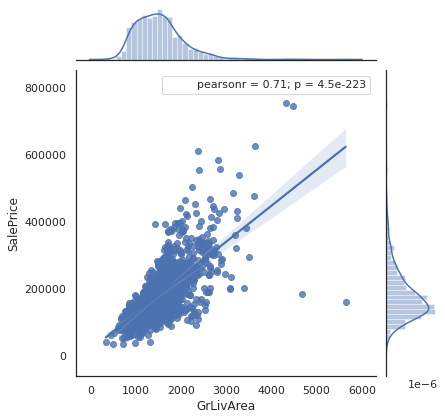

In [7]:
g = sns.jointplot(x = train['GrLivArea'], y = train['SalePrice'],kind="reg")
g.annotate(stats.pearsonr)

Il y a une forte corrélation entre le prix du bien "SalePrice" et la surface habitable "GrLivArea" (coefficient de Pearson: 0.71)

# Expliquer la variable du prix de vente



In [8]:
train['SalePrice'].describe()


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

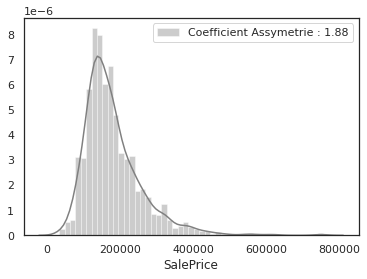

In [9]:
g = sns.distplot(train['SalePrice'],color="gray")
g = g.legend(["Coefficient Assymetrie : {:.2f}".format(train['SalePrice'].skew())],loc='best')

Le coefficient d'assymetrie de la variable `SalePrice` est positif. Cependant les modèles linéaires nécessitent une distribution normale. Il faudra donc transformer cette distribution assymétrique en distribution normale.


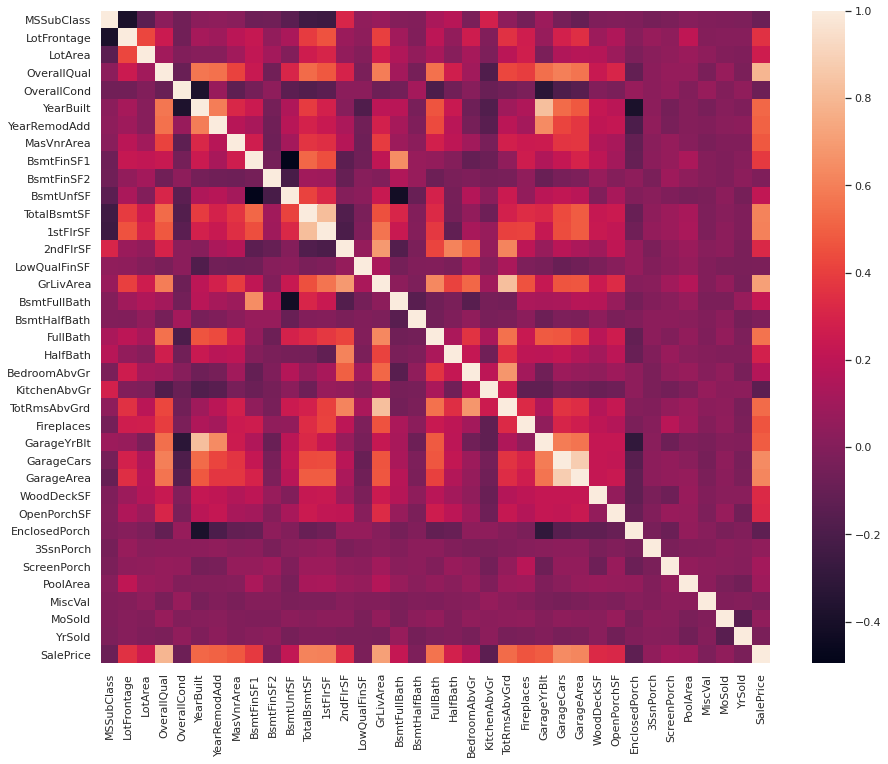

In [13]:
corrmat = train.corr()
plt.subplots(figsize=(15,12))
g = sns.heatmap(train.corr())

Il y a une forte correlation entre `SalePrice` et `OverallQual`, `GrLivArea`, `1stFlrSF`, `GarageCars`, `GarageArea`.
Je selectionne les variables qui ont un coefficient de corrélation supérieur à 0,5 avec `SalePrice`

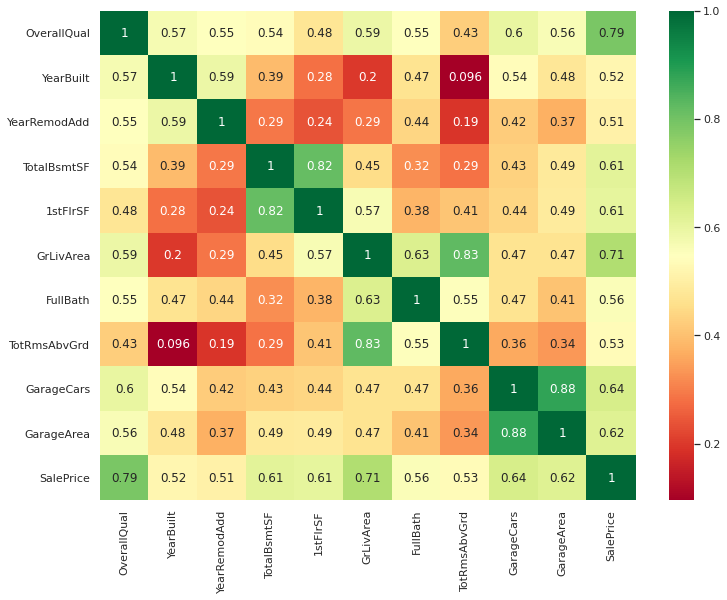

In [17]:
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.subplots(figsize=(12,9))
g = sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Il s'agit de la heatmap des variables les plus corrélées à `SalePrice`. Avec une correlation de 0.79 et 0.71 respectivement, `OverallQual` et `GrLivArea` respectivement, sont les variables les plus fortement corrélées.

Maintenant, je vais explorer les relations entre les variables les plus corrélées à `SalePrice`.

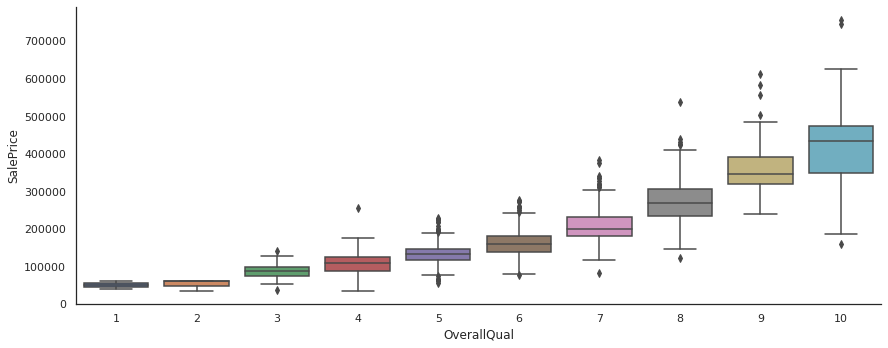

In [18]:
g = sns.factorplot(x="OverallQual",y="SalePrice",data=train,kind='box',aspect=2.5)

Dans le cas de la variable la plus corrélée à `SalePrice` *i.e.* `OverallQual`, la relation linéaire est évidente. Le prix de vente tend à augmenter proportionnellement à la qualité d'ensemble de la maison.

In [ ]:
l

# 5 Transformation des données


In [10]:
def multiplot(data,features,plottype,nrows,ncols,figsize,y=None,colorize=False):
    """ This function draw a multi plot for 3 types of plots ["regplot","distplot","coutplot"]"""
    n = 0
    plt.figure(1)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    
    if colorize:
        colors = sns.color_palette(n_colors=(nrows*ncols))
    else :
        colors = [None]*(nrows*ncols)
        
    for row in range(ncols):
        for col in range(nrows):
            
            if plottype == 'regplot':
                if y == None:
                    raise ValueError('y value is needed with regplot type')
                
                sns.regplot(data = data, x = features[n], y = y ,ax=axes[row,col], color = colors[n])
                correlation = np.corrcoef(data[features[n]],data[y])[0,1]
                axes[row,col].set_title("Correlation {:.2f}".format(correlation))
            
            elif plottype == 'distplot':
                sns.distplot(a = data[features[n]],ax = axes[row,col],color=colors[n])
                skewness = data[features[n]].skew()
                axes[row,col].legend(["Skew : {:.2f}".format(skewness)])
            
            elif plottype in ['countplot']:
                g = sns.countplot(x = data[features[n]], y = y, ax = axes[row,col],color = colors[n])
                g = plt.setp(g.get_xticklabels(), rotation=45)
                
            n += 1
    plt.tight_layout()
    plt.show()
    plt.gcf().clear()

La fonction *multiplot* permet d'afficher 3 figures à partir d'une même donnée:
* La droite de la regression linéaire qui va avec les données
* L'histogramme de la distribution univariée des obersvations
* Barplot du nombre d'observations dans chaque catégorie pour les variables qualitatives